# Setup and Import

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

In [10]:
# Find out the last date in the file
last_day = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_day

('2017-08-23')

In [11]:
# Calculate the date 1 year ago from the last data point in the database
last_year = (dt.datetime.strptime(last_day[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
last_year

'2016-08-23'

In [12]:
# Perform a query to retrieve the data and precipitation scores
precip = (measurement.date, measurement.prcp)

precip_data = session.query(*precip).filter(func.strftime(measurement.date >= last_year)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data)
precip_df.rename(columns = {'date':'Date', 'prcp':'Precipitation'}, inplace = True)
precip_df.set_index('Date', inplace = True)

# Sort the dataframe by date
precip_df_sorted = precip_df.sort_values(by=['Date']) 
precip_df_sorted.head()


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


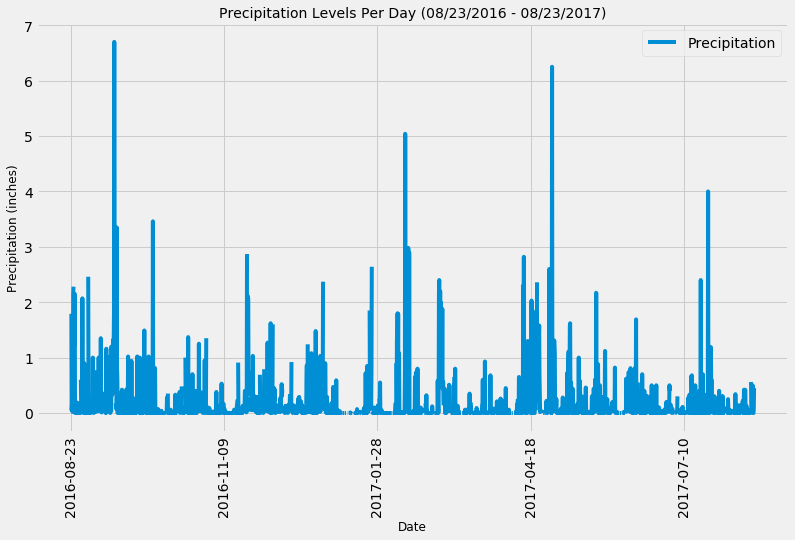

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df_sorted.plot(figsize=(12,7), rot=90)

plt.title("Precipitation Levels Per Day (08/23/2016 - 08/23/2017)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation (inches)", fontsize=12)


# Save image
plt.savefig("images/precipitation.png")

plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df_sorted.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [15]:
# Query the number of stations in the dataset
session.query(station.id).count()


9

In [16]:
# List the stations and the counts in descending order.

station_precip = (measurement.station, func.count(measurement.prcp))

station_precip_totals = session.query(*station_precip).\
                        group_by(measurement.station).\
                        order_by(func.count(measurement.station).desc()).all()
station_precip_totals

[('USC00519281', 2772),
 ('USC00519397', 2685),
 ('USC00513117', 2696),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
                filter(measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations and query the last 12 months of temp observation data.
highest_station = session.query(measurement.date, measurement.tobs).\
                    filter(measurement.station == 'USC00519281').\
                    filter(measurement.date >= last_year).all()


# Create dataframe
highest_station_df = pd.DataFrame(highest_station)
highest_station_df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


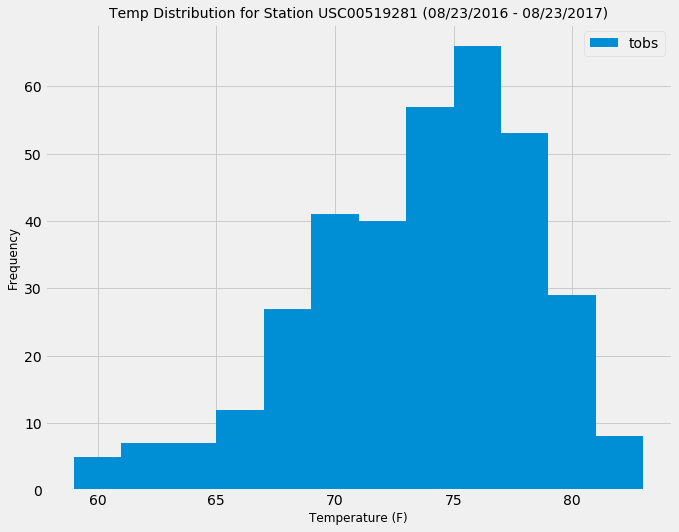

In [19]:
# Create histogram of the results.
highest_station_df.plot(kind='hist', bins=12, figsize=(10,8))

plt.title("Temp Distribution for Station USC00519281 (08/23/2016 - 08/23/2017)", fontsize=14)
plt.xlabel("Temperature (F)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)


# Save image
plt.savefig("images/histogram.png")

plt.show()

# Bonus Challenge Assignment

## Temperature Analysis II

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Vacation Dates
start_date = '2017-06-23'
end_date = '2017-06-30'

temp_stats = calc_temps(start_date, end_date)
temp_stats



[(71.0, 77.08, 82.0)]

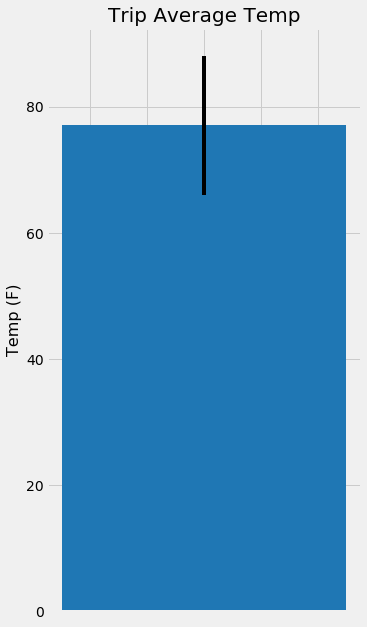

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin = 71.0
tave = 77.08
tmax = 82.0
x_pos = [0]

fig, ax = plt.subplots(figsize=(5,10))
ax.bar(x_pos, tave, yerr = tmax-tmin, width = 0.25,color="tab:blue", align="center")

# Format chart 
plt.title("Trip Average Temp", fontsize=20)
plt.ylabel("Temp (F)", fontsize=16)
plt.tick_params(axis='x',which='both', bottom=False, top=False,labelbottom=False)

# Save image
plt.savefig("images/trip_avg_temp.png")    

plt.show()


## Daily Average Rainfall

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# stackoverflow.com/questions/6044309/sqlalchemy-how-to-join-several-tables-by-one-query

rainfall = (station.station, station.name, station.latitude, station.longitude, station.elevation, func.sum(measurement.prcp))

rainfall_query = session.query(*rainfall).\
                        filter(station.station==measurement.station).\
                        filter(measurement.date >= start_date).\
                        filter(measurement.date <= end_date).\
                        group_by(measurement.station).\
                        order_by(func.sum(measurement.prcp).desc()).all()

rainfall_query_pd = pd.DataFrame(rainfall_query, columns=['Station', 'Station Name', 'Station Lat', 'Station Lng', 
                                                         'Station Elevation', 'Total Precipitation'])
rainfall_query_pd

,Station,Station Name,Station Lat,Station Lng,Station Elevation,Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.60
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.58
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.18
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.14
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.12
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.12
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.00


### Daily Normals

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-06-23'
end_date = '2017-06-30'

# Use the start and end date to create a range of dates
vacation_days = ['2017-06-23', '2017-06-24', '2017-06-25', '2017-06-26', '2017-06-23', '2017-06-28', '2017-06-29', '2017-06-30']

# Stip off the year and save a list of %m-%d strings
days =[dt.datetime.strptime(date, "%Y-%m-%d") for date in vacation_days]

# Stip off the year and save a list of %m-%d strings
final_dates = [date.strftime("%m-%d") for date in days]
final_dates

['06-23', '06-24', '06-25', '06-26', '06-23', '06-28', '06-29', '06-30']

In [26]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normal_list = [daily_normals(dates) for dates in final_dates]
normal_list

[[(68.0, 74.54385964912281, 80.0)],
 [(68.0, 74.96428571428571, 84.0)],
 [(68.0, 74.10344827586206, 80.0)],
 [(67.0, 74.21428571428571, 82.0)],
 [(68.0, 74.54385964912281, 80.0)],
 [(69.0, 74.88679245283019, 80.0)],
 [(67.0, 74.91525423728814, 80.0)],
 [(67.0, 75.59615384615384, 81.0)]]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
# stackoverflow.com/questions/37968730/set-index-name-of-pandas-dataframe

cleaned_list = [item for sublist in normal_list for item in sublist]

normals_df = pd.DataFrame(cleaned_list, index = vacation_days, columns = ['TMIN','TAVE', 'TMAX'])
normals_df.index.name="Date"
normals_df

,TMIN,TAVE,TMAX
Date,,,
2017-06-23,68.0,74.543860,80.0
2017-06-24,68.0,74.964286,84.0
2017-06-25,68.0,74.103448,80.0
2017-06-26,67.0,74.214286,82.0
2017-06-23,68.0,74.543860,80.0
2017-06-28,69.0,74.886792,80.0
2017-06-29,67.0,74.915254,80.0
2017-06-30,67.0,75.596154,81.0


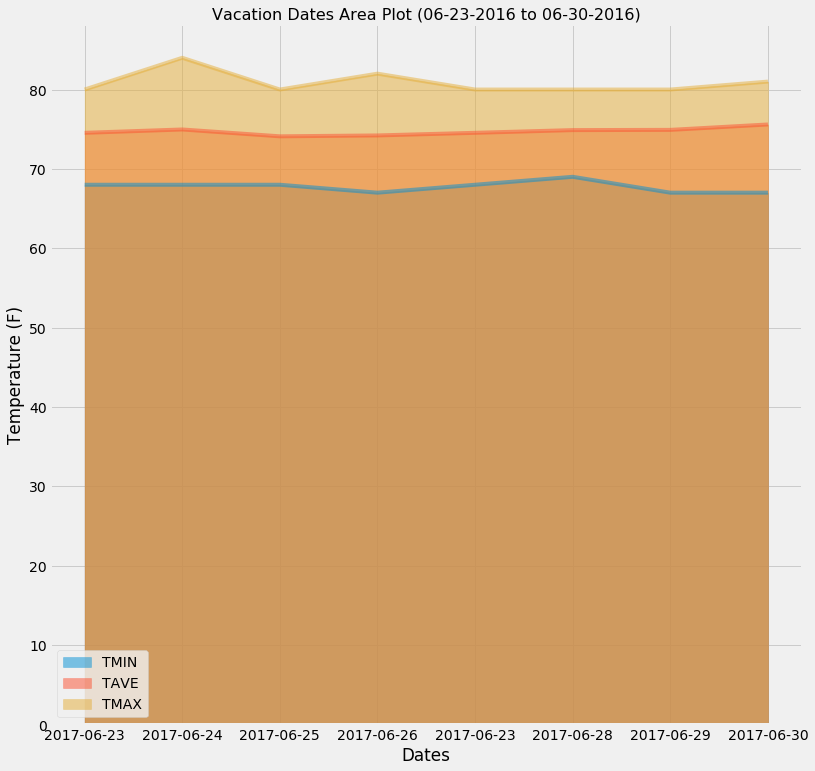

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked=False, figsize=(12, 12))

# Format chart
ax.set_title('Vacation Dates Area Plot (06-23-2016 to 06-30-2016)', fontsize = 16)
ax.set_ylabel('Temperature (F)')
ax.set_xlabel('Dates')

# Save image
plt.savefig("images/area_plot.png")

plt.show()